In [63]:
import time
from pathlib import Path
import numpy as np
from test import Map
import cv2
import matplotlib.pyplot as plt
from ROAR.utilities_module.data_structures_models import Location
from tqdm import tqdm
%matplotlib inline

In [64]:
dir_path = Path("./data/pointcloud_1")
print(f'reading point cloud from {dir_path}')
pcd = Map.read_pointclouds(dir_path=dir_path)
print(f"{pcd} constructed")
scale = 15
buffer = 0
x_offset, y_offset, x_width, y_height = Map.find_hyperparam_from_pcd(pcd=pcd, scale=scale, buffer=buffer)
m = Map(
    x_offset=x_offset, y_offset=y_offset, x_scale=scale, y_scale=scale,
    x_width=x_width, y_height=y_height, buffer=buffer, name="occu_map"
)
points = Map.extract_xz_points_from_pcd(pcd)
m.update(points=points)
# m.visualize()

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(m.map,kernel,iterations = 1)


occu_map = np.ones(shape=(dilation.shape[0], dilation.shape[1]), dtype=np.float32)
occu_map[np.where(dilation > 0.5)] = 0
# plt.imshow(occu_map,cmap='gray')
# plt.show()


nav_map = np.zeros(shape=(occu_map.shape[0], occu_map.shape[1], 3),
                   dtype=np.uint8)
nav_map[np.where(occu_map > 0.5)] = np.array([255, 255, 255]).astype(np.uint8)
# plt.imshow(nav_map)
# plt.show()

reading point cloud from data/pointcloud_1


100%|██████████| 686/686 [00:12<00:00, 53.83it/s]


PointCloud with 131855 points. constructed


In [3]:
occu_map[0][0]

1.0

In [4]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

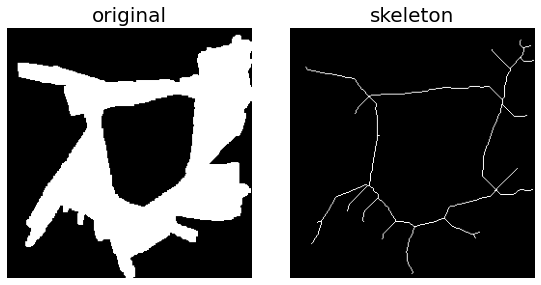

In [6]:
image = invert(occu_map)

# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

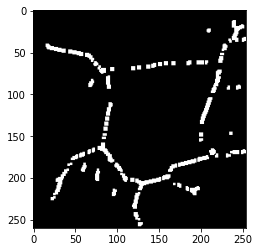

In [61]:
gray = np.float32(skeleton)
dst = cv2.cornerHarris(gray,2,3,0.04)
# result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
mask = dst > 0.01 * dst.max()
# image[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(mask, cmap="gray")

WARNING - 2022-01-01 17:14:54,130 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


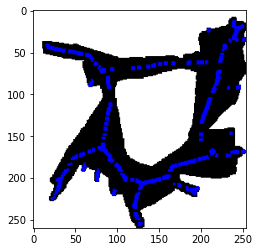

In [62]:
image = np.zeros(shape=(occu_map.shape[0], occu_map.shape[1], 3))
image[occu_map > 0] = [255,255,255]
image[mask] = [0,0,255]
plt.imshow(image)
plt.show()

In [156]:
arr = np.uint8(occu_map)
contours, hierarchy = cv2.findContours(arr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [157]:
def is_contour_correct(contour, map_shape):
    return not (map_shape[0] - 1 in contour or 0 in contour or map_shape[1] - 1 in contour)

Found contour 1 to be the correct contour


Text(0.5, 1.0, 'inner_track_map')

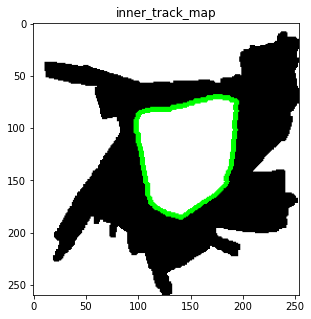

In [158]:
# find the correct contour
correct_contours = [i for i, contour in enumerate(contours) if is_contour_correct(contour, map_shape=occu_map.shape)]
assert len(correct_contours) == 1, "there are multiple or no contour matches"
print(f"Found contour {correct_contours[0]} to be the correct contour")
inner_track_map = np.zeros(shape=(occu_map.shape[0], occu_map.shape[1], 3), dtype=np.uint8)
inner_track_map[np.where(occu_map > 0.5)] = np.array([255, 255, 255]).astype(np.uint8)
img = cv2.drawContours(inner_track_map, [contours[correct_contours[0]]], -1, (0,255,0), 3)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img)
ax.set_title("inner_track_map")

In [169]:
# scale the new contour
def scale_contour(contour, scale:float):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cnt_norm = contour - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)
    return cnt_scaled

Text(0.5, 1.0, 'Scaled Contour')

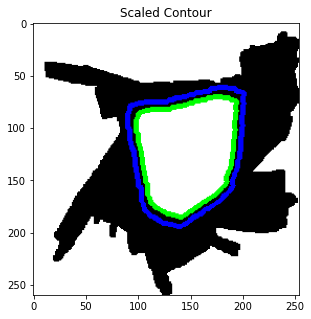

In [181]:
cnt_scaled = scale_contour(contours[correct_contours[0]].copy(), 1.16)
updated_contour_map = np.zeros(shape=(occu_map.shape[0], occu_map.shape[1], 3), dtype=np.uint8)
updated_contour_map[np.where(occu_map > 0.5)] = np.array([255, 255, 255]).astype(np.uint8)
updated_contour_map = cv2.drawContours(updated_contour_map, [contours[correct_contours[0]]], -1, (0,255,0), 3)
updated_contour_map = cv2.drawContours(updated_contour_map, [cnt_scaled], -1, (0,0,255), 3)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(updated_contour_map)
ax.set_title("Scaled Contour")

In [177]:
# contour -> image coordinates
image_coord = cnt_scaled.squeeze() # Nx2

In [179]:
image_coord.shape

(158, 2)